# Pandas Tutorial

![trump](./images/trump.jpg)

In [4]:
!pip install nltk
!pip install -U spacy
!python -m spacy download en
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

import spacy
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

import itertools
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pickle

In [11]:
df = pd.read_csv('data/trump.csv') # might need to change location if on Floydhub

df = df[df.is_retweet=='false']
df.text = df.text.str.lower()

df = df[~df.text.str.startswith('rt')]
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]

df['created_at'] = pd.to_datetime(df['created_at'])

df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,2017-08-07 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,2017-08-07 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,2017-08-07 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday i thank all the brave men a...,2017-08-07 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,2017-08-07 12:01:20,59253,false,8.945289e+17


In [30]:
df.dtypes

source                    object
text                      object
created_at        datetime64[ns]
favorite_count            object
is_retweet                object
id_str                   float64
sentiment                float64
dtype: object

In [18]:
df.created_at.describe()

count                   23902
unique                  23901
top       2016-01-14 05:45:41
freq                        2
first     2009-05-04 18:54:25
last      2017-08-07 20:48:54
Name: created_at, dtype: object

You can use the `apply` statement to use any custom function to be applied along the columns of a dataframe.

## Sentiment Analysis

In [28]:
sia = SIA()
print(sia.polarity_scores('I hate this movie it is aweful')['compound'])
print(sia.polarity_scores('I love this movie it is awesome')['compound'])

-0.5719
0.8519


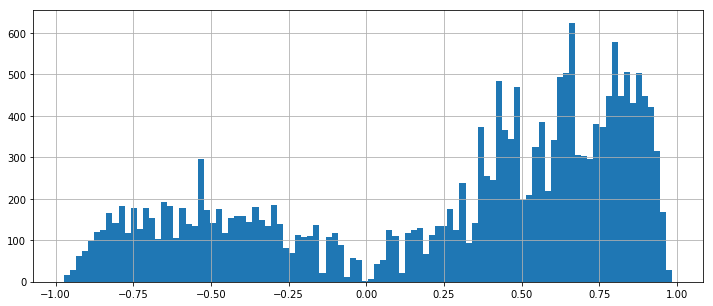

In [23]:
df['sentiment'] = df.text.apply(lambda x: sia.polarity_scores(x)['compound'])
df[np.abs(df.sentiment)>1e-2].sentiment.hist(bins=100, figsize=(12,5))
plt.show()

When you are putting in two conditions you cannot use the usual `and` clause that you would use in a python statement. Instead we have to use the bitwise `&`. It also seems that each conditional statement needs to be wrapped in brackets.

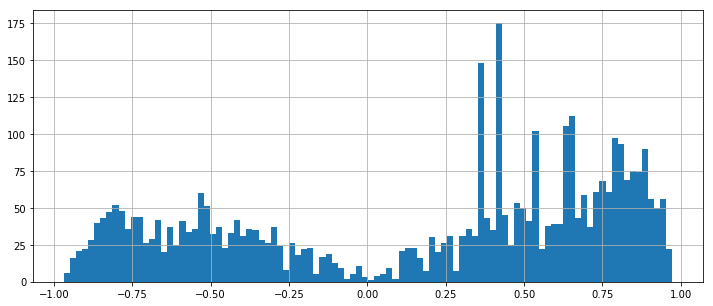

In [26]:
df[(np.abs(df.sentiment)>1e-2) & (df.created_at.dt.year>=2016)].sentiment.hist(bins=100, figsize=(12,5))
plt.show()

See the most used words.

In [35]:
all_tweeets = ' '.join(df.text.values)
all_tweets = re.sub(r'[^a-z ]','', all_tweeets)
words = all_tweeets.split()
words = [word for word in words if word not in stopwords.words('english')]
word_count = Counter(words)
word_count.most_common(20)

[('@realdonaldtrump', 5930),
 ('great', 2778),
 ('trump', 2738),
 ('&amp;', 2085),
 ('-', 1670),
 ('thank', 1390),
 ('donald', 1137),
 ('new', 1061),
 ('would', 1043),
 ('get', 1007),
 ('president', 994),
 ('obama', 983),
 ('like', 977),
 ('people', 967),
 ('make', 894),
 ('one', 822),
 ('america', 758),
 ('big', 708),
 ('run', 698),
 ('time', 692)]

## Tweeting Frequency

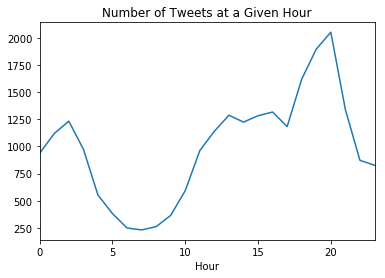

In [44]:
df.groupby(df.created_at.dt.hour).size().plot()
plt.title('Number of Tweets at a Given Hour')
plt.xlabel('Hour')
plt.show()

In [88]:
tweets_perday_perhour = df.groupby([df.created_at.dt.date, df.created_at.dt.hour]).size()
tweets_perday_perhour.index.names = ['day', 'hour']
tweets_perday_perhour = tweets_perday_perhour.reset_index()
tweets_perday_perhour.rename(columns={tweets_perday_perhour.columns[-1]: "tweet_count" }, inplace=True)
tweets_perday_perhour.head()

,day,hour,tweet_count
count,2009-05-04,18,1
1,2009-05-05,1,1
2,2009-05-08,13,1
3,2009-05-08,20,1
4,2009-05-12,14,1


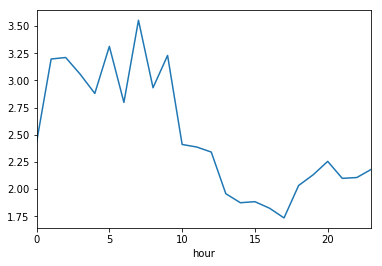

In [108]:
tweet_group = tweets_perday_perhour.groupby('hour').agg({'tweet_count':{'Sum':'sum', 'Mean': 'mean', 'stddev':'std'}})
tweet_group['tweet_count']['Mean'].plot()
# tweet_group['tweet_count']['stddev'].plot()

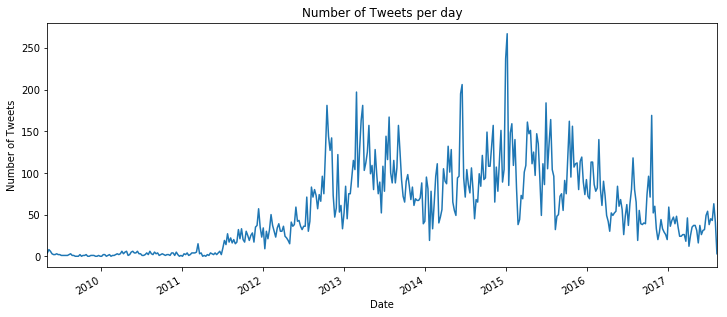

In [29]:
df.groupby(pd.Grouper(key='created_at', freq='7D')).size().plot(figsize=(12,5))
plt.title('Number of Tweets per day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [35]:
nlp = spacy.load('en')

In [55]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for ent in doc.ents:
    print(ent.text, ent.label_)

Apple ORG
U.K. GPE
$1 billion MONEY


## Entity extraction

Unfortunately case matters when it comes to entity recognition so we will reimport the data below. We will also focus only on the tweets from 2016 onwards which I presume are the tweets dealing with the 2016 election. You know, the one that trump lost but won?

In [53]:
df = pd.read_csv('data/trump.csv') # might need to change location if on Floydhub

df = df[df.is_retweet=='false']
df = df[~df.text.str.startswith('RT ')]

df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]

df['created_at'] = pd.to_datetime(df['created_at'])
df = df[df.created_at.dt.year>=2016]
df.shape

(4651, 6)

In [54]:
docs = [nlp(tweet) for tweet in df.text.values]
entities = [doc.ents for doc in docs]
entities = list(itertools.chain.from_iterable(entities))

In [58]:
entities_names = [ent.text.lower() for ent in entities]
Counter(entities_names).most_common(15)

[('hillary', 199),
 ('today', 174),
 ('hillary clinton', 165),
 ('u.s.', 122),
 ('trump2016', 122),
 ('tonight', 112),
 ('america', 102),
 ('american', 100),
 ('tomorrow', 95),
 ('obama', 92),
 ('ted cruz', 89),
 ('trump', 79),
 ('clinton', 77),
 ('obamacare', 76),
 ('ohio', 74)]

In [61]:
entities_types = [ent.label_ for ent in entities]
Counter(entities_types).most_common()

[('ORG', 2416),
 ('PERSON', 2324),
 ('GPE', 2247),
 ('DATE', 843),
 ('MONEY', 713),
 ('NORP', 623),
 ('CARDINAL', 596),
 ('TIME', 456),
 ('ORDINAL', 95),
 ('FAC', 89),
 ('PERCENT', 78),
 ('WORK_OF_ART', 71),
 ('PRODUCT', 61),
 ('LOC', 60),
 ('EVENT', 46),
 ('LAW', 26),
 ('QUANTITY', 8),
 ('LANGUAGE', 3)]

In [63]:
people = [ent.text.lower() for ent in entities if ent.label_=='PERSON']
Counter(people).most_common(15)

[('hillary', 199),
 ('hillary clinton', 165),
 ('ted cruz', 89),
 ('obama', 81),
 ('clinton', 69),
 ('cruz', 66),
 ('crooked hillary', 56),
 ('trump2016', 56),
 ('donald trump', 44),
 ('bernie sanders', 34),
 ('trump', 29),
 ('vote', 28),
 ('marco rubio', 27),
 ('bernie', 18),
 ("hillary clinton's", 16)]

In [64]:
geo = [ent.text.lower() for ent in entities if ent.label_=='GPE']
Counter(geo).most_common(15)

[('u.s.', 122),
 ('america', 102),
 ('ohio', 74),
 ('florida', 72),
 ('russia', 66),
 ('iowa', 59),
 ('maga', 47),
 ('new hampshire', 46),
 ('pennsylvania', 42),
 ('melania', 37),
 ('china', 35),
 ('indiana', 34),
 ('south carolina', 33),
 ('mexico', 32),
 ('new york', 30)]

In [65]:
org = [ent.text.lower() for ent in entities if ent.label_=='ORG']
Counter(org).most_common(15)

[('obamacare', 59),
 ('@nytimes', 46),
 ('cnn', 35),
 ('fbi', 32),
 ('@realdonaldtrump', 29),
 ('senate', 27),
 ('gop', 27),
 ('trump', 27),
 ('dnc', 25),
 ('@whitehouse', 25),
 ('the republican party', 20),
 ('congress', 18),
 ('the white house', 18),
 ('rubio', 17),
 ('state', 16)]

In [67]:
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one

In [74]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=2000, stop_words='english')
tf = tf_vectorizer.fit_transform(df.text.values)

In [78]:
# Reference: http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [81]:
lda = LatentDirichletAllocation(n_components=5)
lda.fit(tf)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 10)

/root/miniconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)



Topics in LDA model:
Topic #0: thank great trump2016 makeamericagreatagain today realdonaldtrump tonight amp support enjoy
Topic #1: hillary clinton trump crooked media president obama campaign amp want
Topic #2: america great make new going people realdonaldtrump americafirst love states
Topic #3: cruz join just said ted iowa amp republican maga rubio
Topic #4: amp cnn jobs new people time great let poll trump

